# World Wide Products Inc.

## Introduction

The dataset used in this project contains observations from a variety of products. The products are labeled by a number code only. Each observation also consists of each product's associated warehouse, category code, and date ordered.  The purpose of this project is to use time series models to model and predict the target variable (Product demand, measured by the variable Order_Demand). I will prepare the data for prediction and then perform several models on two products -- Product 0979 and Product 0704 --  which I chose based on their visual distribution and differing number of observations.

In [659]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pmdarima import auto_arima 

import warnings
warnings.filterwarnings("ignore")

In [653]:
def perform_adf_test(series):
    result=adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' %result[1])

In [518]:
airline = pd.read_csv('/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-5-Khan/Data/RawData/HistoricalProductDemand.csv', index_col ='Date', parse_dates = True)

In [519]:
print(airline.index.freq)

None


In [520]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-5-Khan/Data/RawData/HistoricalProductDemand.csv")
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [521]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [522]:
#new = df["Product_Code"].str.split("_", n = 1, expand = True)
#df["Code"]=new[1]

In [523]:
#new = df["Product_Category"].str.split("_", n = 1, expand = True)
#df["Category"]=new[1]
#df.head()

In [524]:
#df['Code'] = df['Code'].astype('float')
#df['Category'] = df['Category'].astype('float')
df['Warehouse'] = df['Warehouse'].astype('string')
df['Date'] = df['Date'].astype('string')
df['Product_Category'] = df['Product_Category'].astype('string')
df['Product_Code'] = df['Product_Code'].astype('string')
df.dtypes

Product_Code        string
Warehouse           string
Product_Category    string
Date                string
Order_Demand        object
dtype: object

In [525]:
df['Order_Demand'] = df['Order_Demand'].astype('string')

In [526]:
df.Order_Demand = df.Order_Demand.str.strip()

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  string
 1   Warehouse         1048575 non-null  string
 2   Product_Category  1048575 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1048575 non-null  string
dtypes: string(5)
memory usage: 40.0 MB


In [528]:
df.dropna(subset = ["Date"], inplace=True)
#df['Date']=df['Date'].str.replace("/","").astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1037336 non-null  string
 1   Warehouse         1037336 non-null  string
 2   Product_Category  1037336 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1037336 non-null  string
dtypes: string(5)
memory usage: 47.5 MB


In [529]:
df=df.reset_index()
df.drop(columns =["index"], inplace = True)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [530]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if("(" in df['Order_Demand'][i]):
        df['Order_Demand'][i] = df['Order_Demand'][i].rstrip(")")
        df['Order_Demand'][i] = df['Order_Demand'][i].lstrip("(")
        df['Order_Demand'][i] = "-" + df['Order_Demand'][i]
        count=count+1
        #df.drop([i], inplace=True, axis=0)
        if(count<3):
            print(df.iloc[i])
            
print('Times Order_Demand variable is negative =', count)

Product_Code        Product_2169
Warehouse                 Whse_A
Product_Category    Category_024
Date                    2012/8/9
Order_Demand                  -1
Name: 112289, dtype: string
Product_Code        Product_2132
Warehouse                 Whse_A
Product_Category    Category_009
Date                   2012/11/1
Order_Demand                 -24
Name: 112306, dtype: string
Times Order_Demand variable is negative = 5899


In [531]:
df['Order_Demand'] = df['Order_Demand'].astype('float')

In [532]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if(df['Order_Demand'][i] < 0):
        #print(df.iloc[i])
        #df.drop([i],inplace=True, axis=0)
        df['Order_Demand'][i] = (df['Order_Demand'][i])*(-1)
        count=count+1
        
            
print('Times Order_Demand variable is negative =', count)

<ipython-input-532-5b9b71c14f8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order_Demand'][i] = (df['Order_Demand'][i])*(-1)


Times Order_Demand variable is negative = 5899


In [534]:
df.dtypes

Product_Code         string
Warehouse            string
Product_Category     string
Date                 string
Order_Demand        float64
dtype: object

In [536]:
df.Date = pd.to_datetime(df.Date, format='%y/%d/%m')
df.set_index('Date', inplace=True)

In [539]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['WeekdayName'] = df.index.dayofweek
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,WeekdayName
Date,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100.0,2012,7,4
2012-01-19,Product_0979,Whse_J,Category_028,500.0,2012,1,3
2012-02-03,Product_0979,Whse_J,Category_028,500.0,2012,2,4
2012-02-09,Product_0979,Whse_J,Category_028,500.0,2012,2,3
2012-03-02,Product_0979,Whse_J,Category_028,500.0,2012,3,4


In [551]:
#df.loc['2012-01-17']

# Datasets for individual products

In [582]:
dfProd=df.query("Product_Code == 'Product_0704'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-03-02,Product_0704,Whse_J,Category_001,1.0
2012-01-17,Product_0704,Whse_J,Category_001,10.0
2012-02-14,Product_0704,Whse_J,Category_001,10.0
2012-03-07,Product_0704,Whse_J,Category_001,10.0
2012-05-15,Product_0704,Whse_J,Category_001,10.0


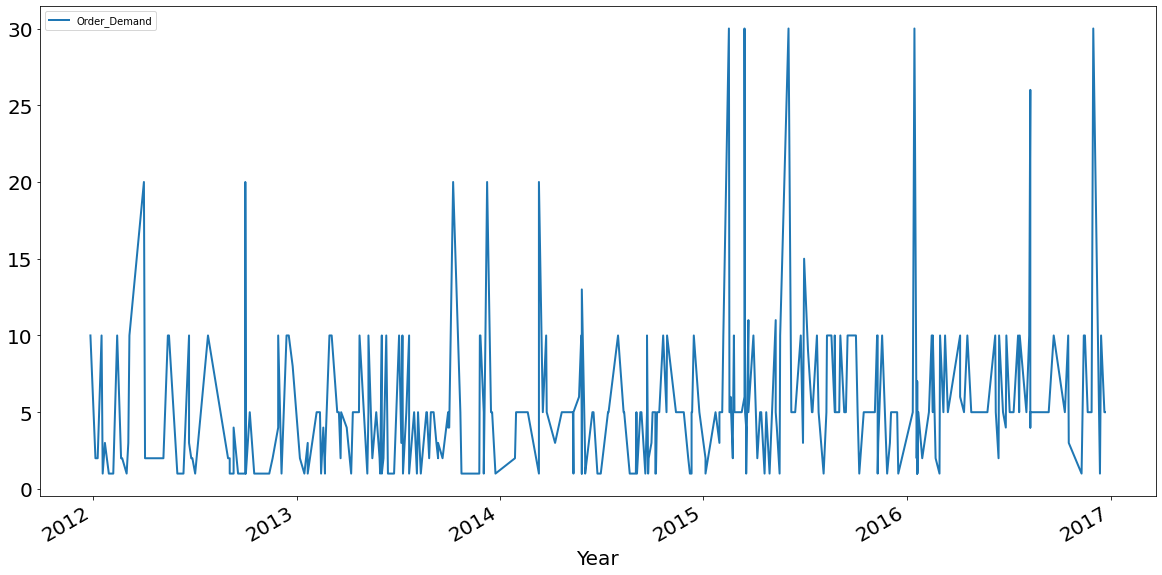

In [583]:
dfProd.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [584]:
dfProd2=df.query("Product_Code == 'Product_0979'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd2.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0
2012-04-19,Product_0979,Whse_J,Category_028,500.0


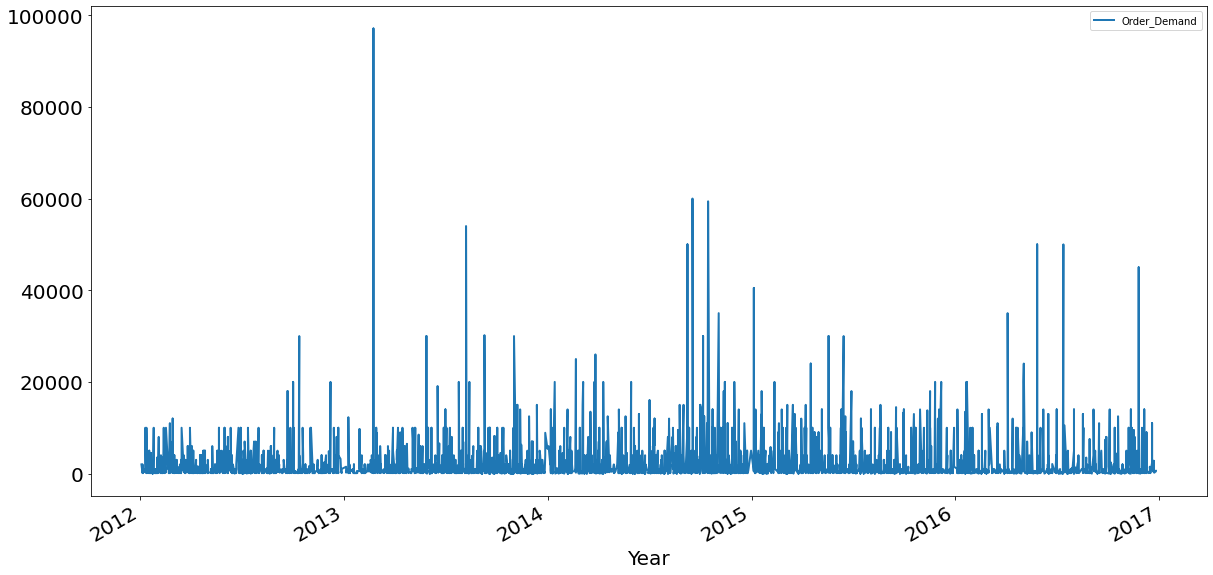

In [585]:
dfProd2.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [586]:
dfProd_check=dfProd[['Order_Demand']]
dfProd2_check=dfProd2[['Order_Demand']]

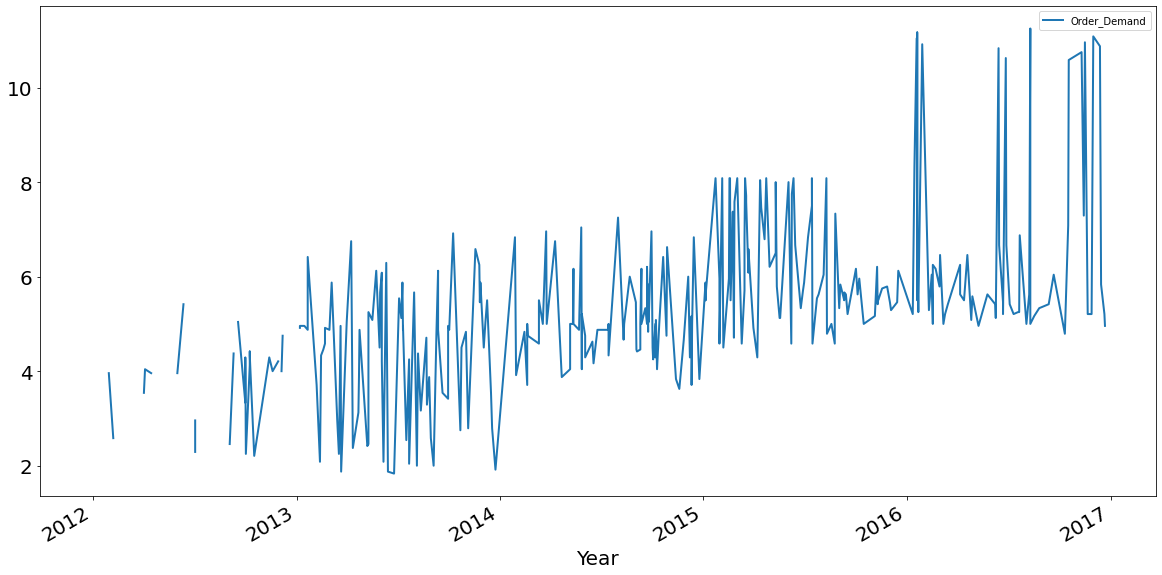

In [656]:
dfProd_check.rolling(24).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [588]:
result = adfuller(dfProd_check['Order_Demand'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.310951310856493
p-value: 0.0004252098426042608
Critical Values:
	1%: -3.450081345901191
	5%: -2.870232621465807
	10%: -2.571401168202517


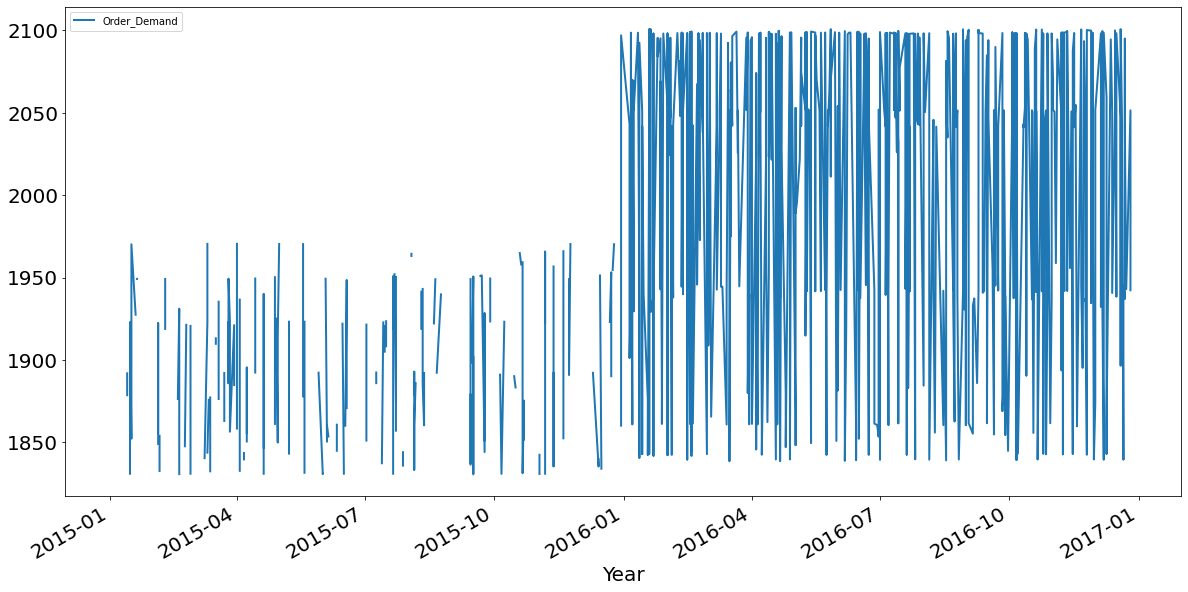

In [658]:
dfProd2_check.rolling(3000).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [590]:
result = adfuller(dfProd2['Order_Demand'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -11.307303787535423
p-value: 1.2639932496515664e-20
Critical Values:
	1%: -3.43203824459253
	5%: -2.8622859739495463
	10%: -2.5671670910000524


In [594]:
df.dtypes

Product_Code         string
Warehouse            string
Product_Category     string
Order_Demand        float64
Year                  int64
Month                 int64
WeekdayName           int64
dtype: object

In [624]:
type(df.index)
print(df.index.freq)

None


In [617]:
dfProd=dfProd.groupby(level=0).sum()
dfProd2=dfProd2.groupby(level=0).sum()

In [626]:
dfProd = dfProd.asfreq('M', method='ffill')
dfProd2 = dfProd2.asfreq('M', method='ffill')

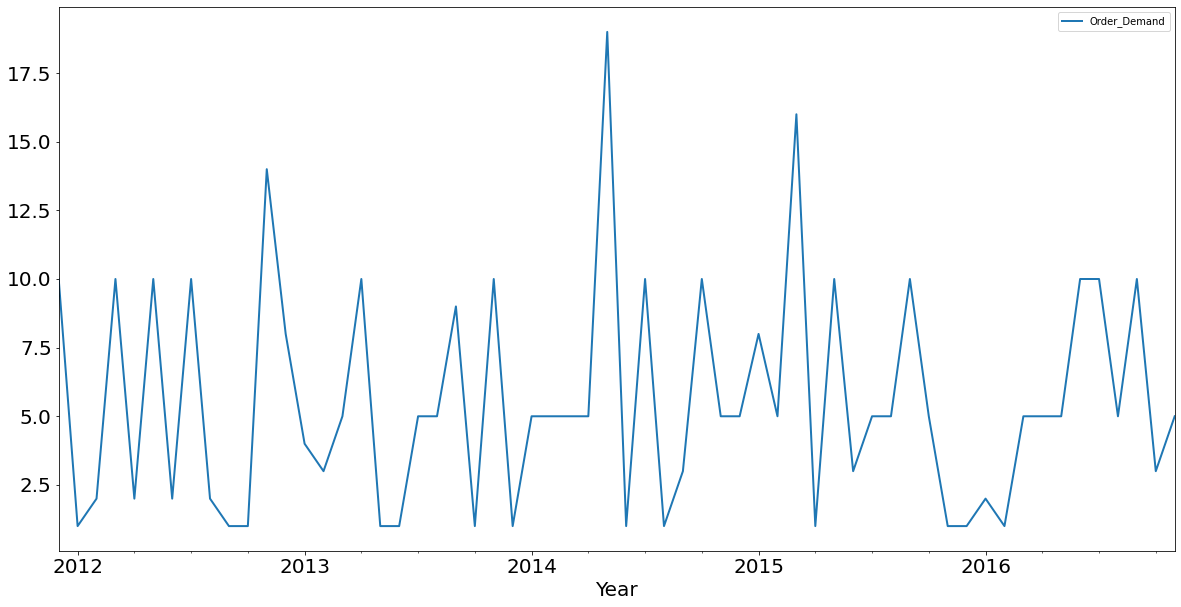

In [619]:
dfProd.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

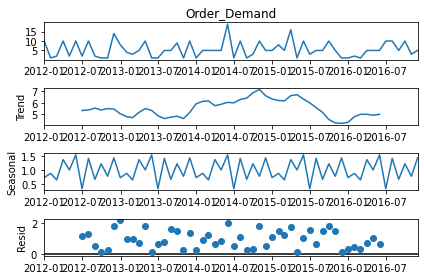

In [623]:
# ETS Decomposition 
result = seasonal_decompose(dfProd['Order_Demand'], model ='multiplicative') 
  
# ETS plot  
fig=result.plot()
fig.show()

In [614]:
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(dfProd['Order_Demand'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=308.136, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=297.882, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=295.563, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=306.141, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=308.805, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=297.427, Time=0.12 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=297.414, Time=0.17 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=297.936, Time=0.07 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=295.620, Time=0.10 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=293.618, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -143.809
Date:                            Sun, 11 Oct 2020   AIC                            293.618
Time:                                    16:16:56   BIC                            299.232
Sample:                                         0   HQIC                           295.740
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1511      0.173     -0.875      0.382      -0.490       0.187
ma.S.L12      -0.8546      0.708     -1.207      0.227      -2.242       0.533
sigma2        17.8872     11.834      1.511      0.131      -5.308      41.082
===================================================================================
Ljung-Box (Q):                       36.63   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.62   Prob(JB):                         0.41
Heteroskedasticity (H):               1.26   Skew:                             0.47
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [615]:
# Split data into train / test sets 
train = dfProd.iloc[:len(dfProd)-12] 
test = dfProd.iloc[len(dfProd)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Order_Demand'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Order_Demand   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -109.890
Date:                            Sun, 11 Oct 2020   AIC                            229.781
Time:                                    16:18:03   BIC                            237.558
Sample:                                12-31-2011   HQIC                           232.465
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9995    101.524     -0.010      0.992    -199.984     197.985
ar.S.L12       0.4349   2.09e+05   2.08e-06      1.000    -4.1e+05     4.1e+05
ar.S.L24       0.4816   1.08e+05   4.44e-06      1.000   -2.12e+05    2.12e+05
ma.S.L12      -0.9649   2.31e+05  -4.18e-06      1.000   -4.53e+05    4.53e+05
sigma2        24.8316   5.41e+05   4.59e-05      1.000   -1.06e+06    1.06e+06
===================================================================================
Ljung-Box (Q):                       31.30   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.60   Prob(JB):                         0.55
Heteroskedasticity (H):               0.93   Skew:                             0.45
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

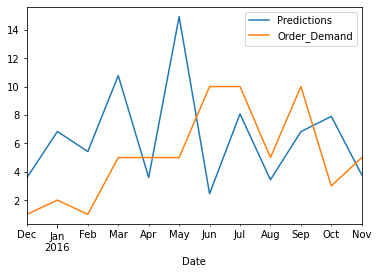

In [616]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Order_Demand'].plot(legend = True) 

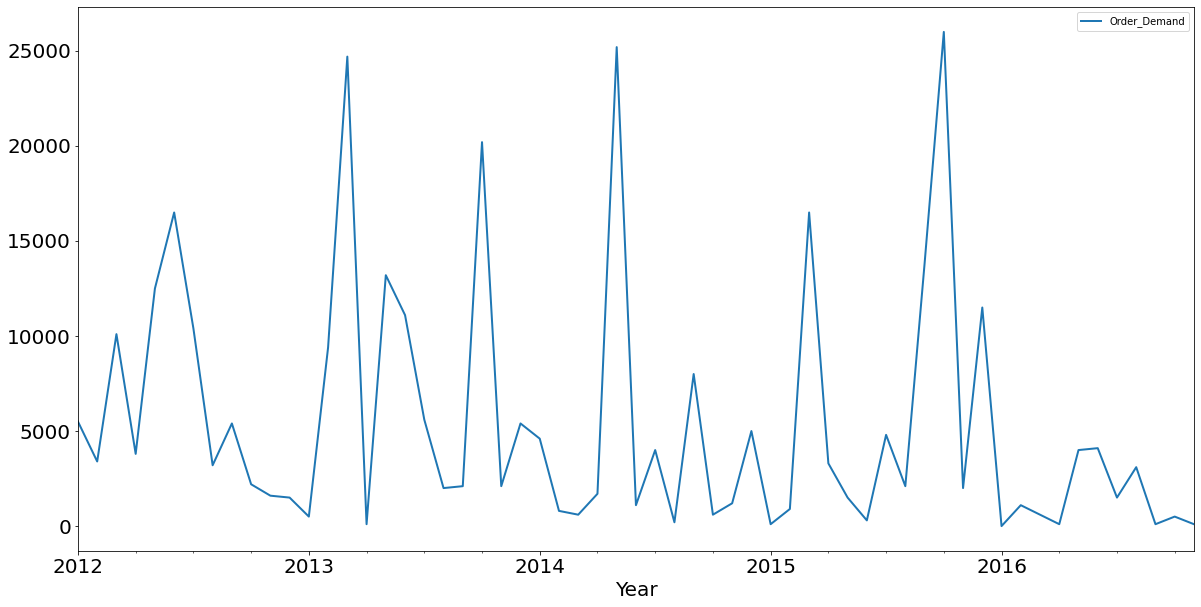

In [620]:
dfProd2.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

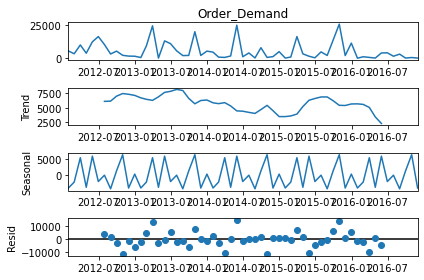

In [627]:
# ETS Decomposition 
result = seasonal_decompose(dfProd2['Order_Demand'], model ='additive') 
  
# ETS plot  
fig=result.plot()
fig.show()

In [628]:
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(dfProd2['Order_Demand'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1003.006, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=987.611, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=990.301, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1001.577, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1004.482, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=980.837, Time=0.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=990.389, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=976.971, Time=0.26 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=989.312, Time=0.05 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=990.141, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=981.281, Time=1.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   59
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -483.485
Date:                              Sun, 11 Oct 2020   AIC                            976.971
Time:                                      17:28:05   BIC                            986.221
Sample:                                           0   HQIC                           980.452
                                               - 59                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    398.5652    618.031      0.645      0.519    -812.754    1609.885
ar.L1          0.1850      0.166      1.116      0.264      -0.140       0.510
ar.S.L12      -0.3274      0.155     -2.114      0.035      -0.631      -0.024
ma.S.L12      -0.8346      0.247     -3.377      0.001      -1.319      -0.350
sigma2      4.531e+07      0.010   4.76e+09      0.000    4.53e+07    4.53e+07
===================================================================================
Ljung-Box (Q):                       32.25   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.80   Prob(JB):                         0.05
Heteroskedasticity (H):               0.94   Skew:                             0.83
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+26. Standard errors may be unstable.
"""

In [629]:
# Split data into train / test sets 
train = dfProd2.iloc[:len(dfProd2)-12] 
test = dfProd2.iloc[len(dfProd2)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Order_Demand'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Order_Demand   No. Observations:                   47
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -355.452
Date:                            Sun, 11 Oct 2020   AIC                            720.905
Time:                                    17:28:31   BIC                            728.536
Sample:                                01-31-2012   HQIC                           723.507
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8519      0.160     -5.324      0.000      -1.166      -0.538
ar.S.L12       0.0303      0.086      0.354      0.723      -0.138       0.198
ar.S.L24       0.9694      0.128      7.570      0.000       0.718       1.220
ma.S.L12      -0.9984      0.255     -3.918      0.000      -1.498      -0.499
sigma2      5.689e+07   4.34e-09   1.31e+16      0.000    5.69e+07    5.69e+07
===================================================================================
Ljung-Box (Q):                       35.93   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.33   Prob(JB):                         0.72
Heteroskedasticity (H):               0.73   Skew:                             0.33
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+31. Standard errors may be unstable.
"""

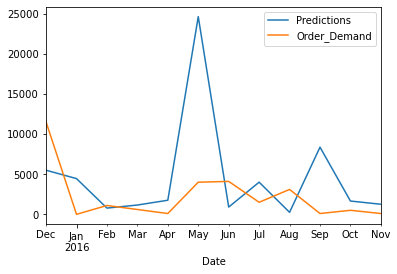

In [630]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Order_Demand'].plot(legend = True) 

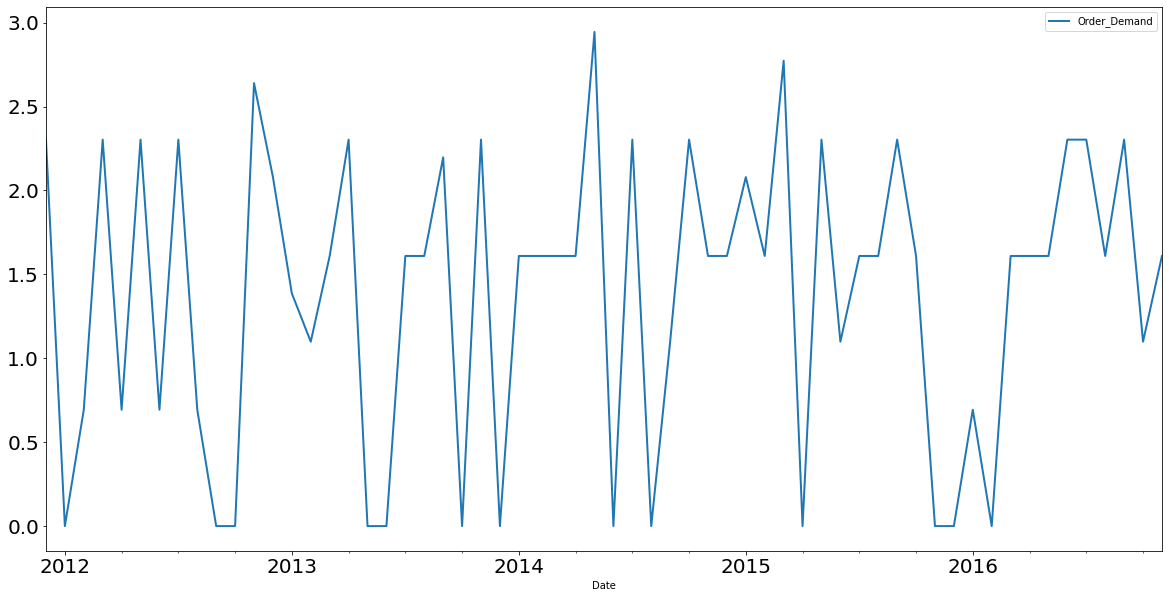

In [632]:
df_log = np.log(dfProd)
df_log.plot(figsize=(20,10), linewidth=2, fontsize=20)

In [633]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

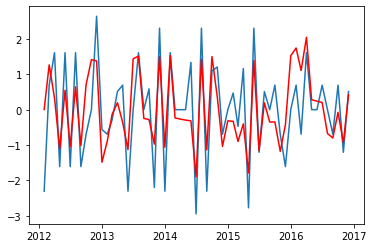

In [636]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

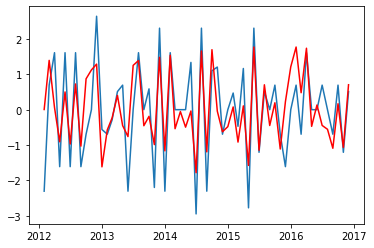

In [641]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(1,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

In [645]:
dfprod_shift = dfProd - dfProd.shift()
dfprod_shift.dropna(inplace=True)

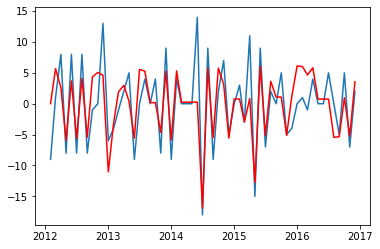

In [646]:
decomposition = seasonal_decompose(dfProd) 
model = ARIMA(dfProd, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(dfprod_shift)
plt.plot(results.fittedvalues, color='red')

In [647]:
dfprod2_shift = dfProd2 - dfProd2.shift()
dfprod2_shift.dropna(inplace=True)

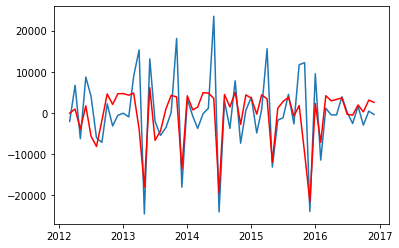

In [665]:
decomposition = seasonal_decompose(dfProd2) 
model = ARIMA(dfProd2, order=(1,1,1)) # (10, 0, 0) is AR(10), (1, 0, 1) is ARMA(1,1)
results = model.fit(disp=-1)
plt.plot(dfprod2_shift)
plt.plot(results.fittedvalues, color='red')

In [654]:
perform_adf_test(dfProd['Order_Demand'])

ADF Statistic: -10.069281
p-value: 0.000000


In [655]:
perform_adf_test(dfProd2['Order_Demand'])

ADF Statistic: -7.236250
p-value: 0.000000
